### Udacity Self-Driving Car Engineer Nanodegree
# Project 5 &mdash; Vehicle Detection 
--- 


## Overview

#### The goals and steps of this project are:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
1. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
  * Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
1. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
1. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
1. Estimate a bounding box for vehicles detected.

---

---

## Step 0 | Project Setup

### Imports

In [290]:
from collections import deque
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import os
import pandas
import pickle
from scipy.ndimage.measurements import label
import skimage
from skimage import data, color, exposure
from skimage.feature import hog
from skimage.transform import resize
import sklearn
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

# Show plots in notebook
%matplotlib inline

### Important Functions
Adapted versions of the key functions used during the Udacity lessons and exercises pertaining to this project.

In [291]:
def add_heat(heatmap, bbox_list):
    '''Adds bounding boxes to a heatmap.
    '''
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assumes each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap


def apply_threshold(heatmap, threshold):
    '''Removes pixels from bounding boxes below a certain threshold.
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap


def bin_spatial(img, size=(32, 32)):
    '''Computes binned color features.
    '''
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''Computes color histogram features.
    
    NOTE: Need to change bins_range if reading .png files with mpimg!
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def draw_boxes(img, bboxes, color=(129, 255, 110), thickness=4):
    '''Draws bounding boxes onto an image.'''
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color=color, thickness=thickness)
    
    # Return the image copy with boxes drawn
    return imcopy


def draw_labeled_bboxes(img, labels, color=(129, 255, 110), thickness=5):
    '''Draws labeled bounding boxes for each detected vehicle.
    '''
    # Iterate through all detected cars
    rects = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color=color, thickness=thickness)
    
    # Return the image and final rectangles
    return img, rects


def extract_features(imgs, cspace='RGB', orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    '''Extract features from a list of image locations. 
    '''
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(hog_features)
    
    # Return list of feature vectors
    return features


def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    '''Single function for extracting features and making predictions via hog sub-sampling.
    '''
    rectangles = []
    
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]

    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)

    # Rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Select colorspace channel for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1
    nfeat_per_block = orient*cell_per_block**2
    
    # Window size and sampling rate
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = svc.predict(hog_features)

            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return rectangles


def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    '''Return HOG features and visualization.
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features
   

### Data Import & Pre-processing
Here we import the dataset which contains vehicle and non-vehicle images with a resolution of 64x64. We also examine it to make sure it matches our expections. Then split the data and add the appropriate labels. 

In [292]:
vehicles = glob.glob("data/vehicles/*/*.png")
non_vehicles = glob.glob("data/non-vehicles/*/*.png")

# Read X vector
X = []
for file in vehicles:    
    X.append(mpimg.imread(file))
for file in non_vehicles:    
    X.append(mpimg.imread(file))
X = np.array(X)

# Generate y vector
y = np.concatenate([np.ones(len(vehicles)), np.zeros(len(non_vehicles))])

# Check results
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (17760, 64, 64, 3)
y shape: (17760,)


### Data Visualization &mdash; Preview Training Images & Labels
Here we do a quick spot check to make sure the images and labels match. 1 for vehicle, 0 for non-vehicle

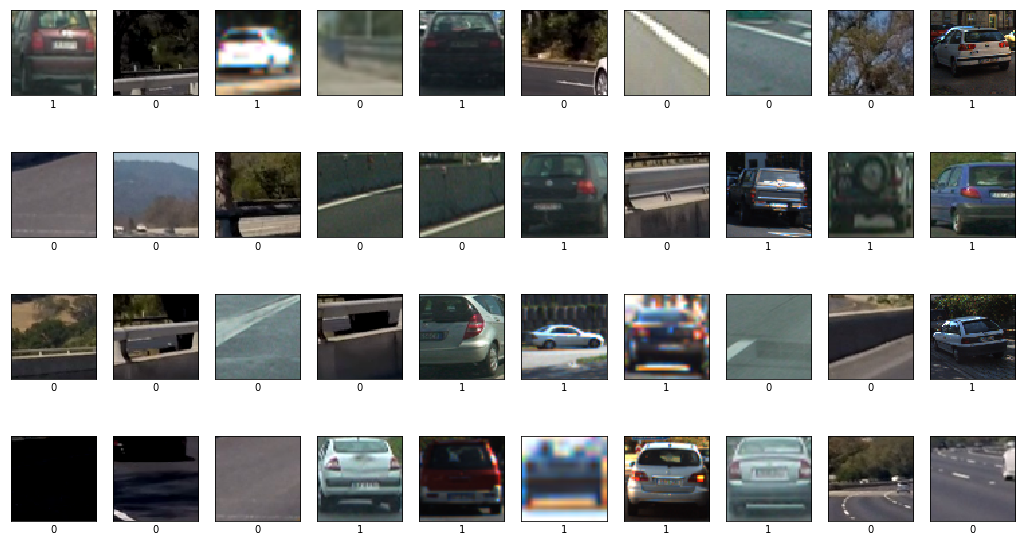

In [293]:
def preview_images(n):
    fig = plt.figure(figsize=(18, 10))
    for i in range(0, n):
        index = np.random.randint(0, len(X))
        axis = fig.add_subplot(4,10,i+1)
        axis.set_xlabel(int(y[index]))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        axis.imshow(X[index])
    plt.show()

preview_images(40)

&nbsp;

---

## Step 1 | Histogram of Oriented Gradients (HOG)
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier


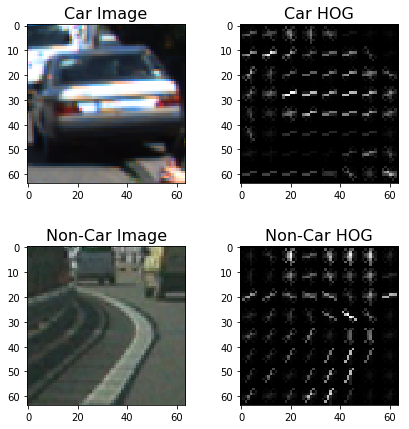

In [78]:
randint = np.random.randint(0, len(non_vehicles))

car_img = mpimg.imread(vehicles[randint])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_img = mpimg.imread(non_vehicles[randint])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize results
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

&nbsp;

---

## Step 2 | Apply Color Transform
Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

In [280]:
# Feature extraction parameters
colorspace = 'YUV'  # RGB, HLS, HSV, LUV, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2, 'ALL'

t1 = time.time()

car_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()

print('Extraction complete.')
print('Time: {0:0.1f} seconds'.format(t2-t1))

Extraction complete.
Time: 88.5 seconds


In [281]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler (only necessary when combining different feature types, eg. HOG + color_hist)
# X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split data into training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Verify splits
print('Training samples:', X_train.shape[0])
print('Training labels:', y_train.shape[0])
print('Test samples:', X_test.shape[0])
print('Test labels:', y_test.shape[0])

Training samples: 14208
Training labels: 14208
Test samples: 3552
Test labels: 3552


### Distribution
Here we check to make sure the data distribution is balanced. I only did this on the first few passes as a sanity check. 

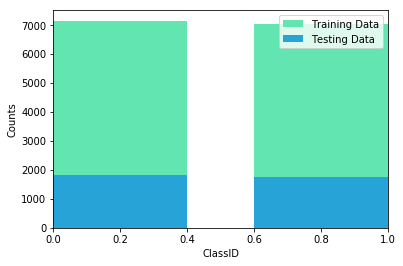

In [104]:
def show_distribution():
    _, training_counts = np.unique(y_train, return_counts = True)
    _, test_counts = np.unique(y_test, return_counts = True)
    plt.bar( np.arange( 2 ), training_counts,   color='#62E5B1', label='Training Data')
    plt.bar( np.arange( 2 ), test_counts,  color='#28A3D8', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([0, 1])
    plt.legend()
    plt.show()
    
show_distribution()

In [282]:
# Assign a classifier
clf = LinearSVC()
# clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=10, random_state=0)
# clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1,max_depth=None, min_samples_split=10, random_state=0)

# Train/fit the classifier
t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Training time: {0:.2f} seconds'.format(t2-t1))

# Calculate accuracy
acc = clf.score(X_test, y_test)
print('Test Accuracy: {0:.4f}'.format(acc))

# Check the predictions for a small sample
t3 = time.time()
n_predict = 15
print('Predictions:', clf.predict(X_test[0:n_predict]))
print('Labels:     ', y_test[0:n_predict])
t4 = time.time()
print('Prediction time: {0:.5f} seconds'.format(t4-t3))

Training time: 7.91 seconds
Test Accuracy: 0.9851
Predictions: [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.]
Labels:      [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.]
Prediction time: 0.00176 seconds


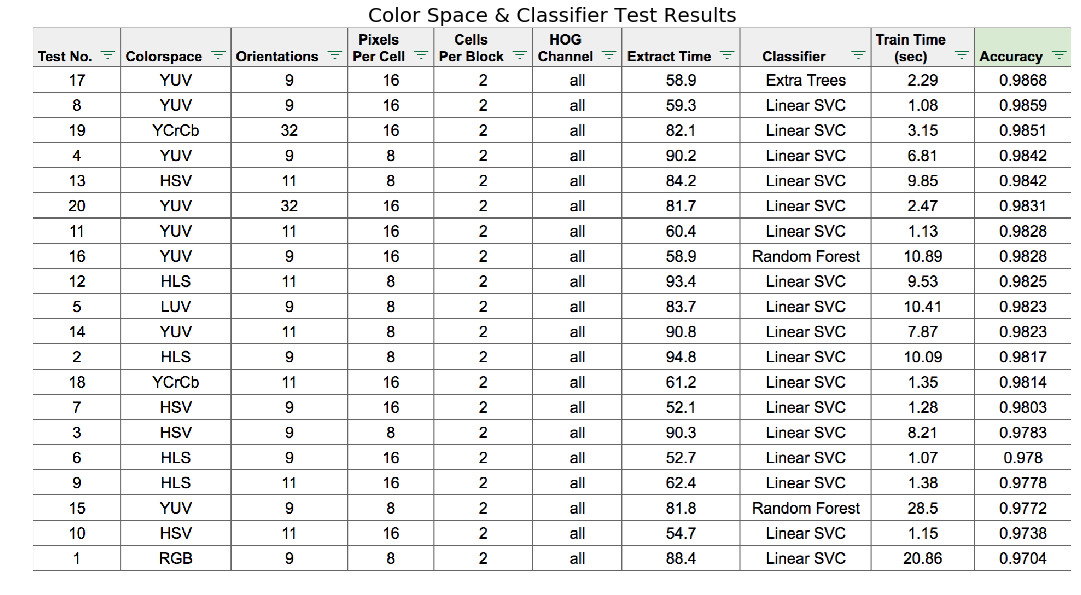

In [276]:
# Show test results 
results = mpimg.imread('results/classifier-test-results.png')
f, ax1 = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(results)
plt.axis('off')
ax1.set_title('Color Space & Classifier Test Results', fontsize=20)

#### TESTING NOTES:
1. Regarding choice of classifier &mdash; I decided to focus most of the testing on LinearSVC since it had a prediction time 67 times faster than the other highest performing classifier (ExtraTrees).
1. Regarding choice of HOG channel &mdash; After a few initial tests, I was not seeing good results with 0, 1, and 2 channels. So, I focused my main testing effort using 'ALL' channels, which performed the best across all color spaces.
1. Regarding choice of color channel &mdash; I chose YUV over YCrCb for my final model because its faster extraction and training time. 

&nbsp;

---

## Step 3 | Implement Sliding Window
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.


Rectangles found: 4


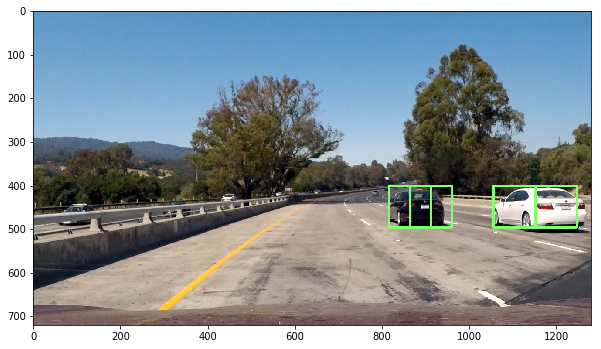

In [149]:
test_img = mpimg.imread('test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV'  # RGB, HSV, LUV, HLS, YUV
orient = 9
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2, 'ALL'

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, \
                       orient, pix_per_cell, cell_per_block, None, None)

print('Rectangles found:', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles)
pltShow All Potential Search Areas.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Show Search Area

Number of boxes: 76


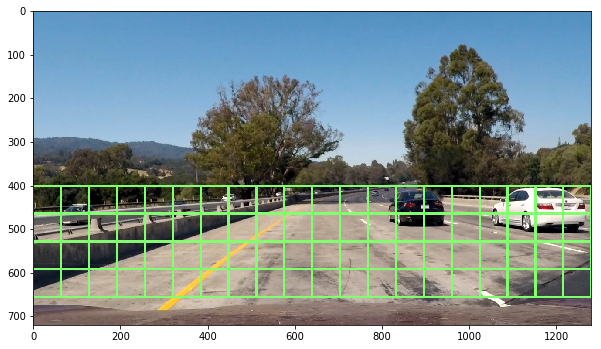

In [162]:
# Make adjustments to cover entire road

test_img = mpimg.imread('test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes:', len(rectangles))

### Combine Multiple Sliding Window Searches

In [286]:
def mult_sliding_windows(test_img, colorspace='YUV', orient=9, pix_per_cell=16, cell_per_block=2, hog_channel='ALL'):

    rectangles = []

    # 64 pixel windows
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 96 pixel windows
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 128 pixel windows
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 592
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 196 pixel windows
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # 256 pixel window
    ystart = 400
    ystop = 656
    scale = 4.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))


    rectangles = [item for sublist in rectangles for item in sublist]

    return rectangles

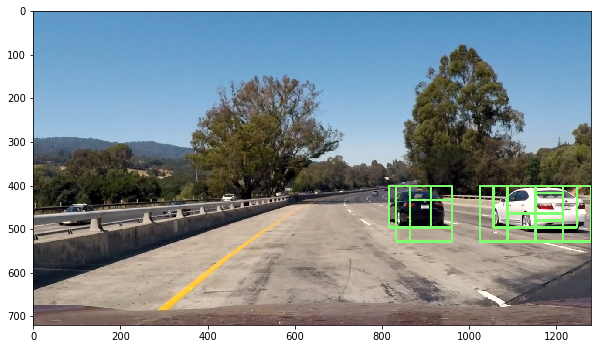

In [181]:
# Visualize window clusters / positive detections

test_img = mpimg.imread('test_images/test1.jpg')
rectangles = mult_sliding_windows(test_img)
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Heatmap
Create a heatmap which shows areas with the highest number of windows / detections.

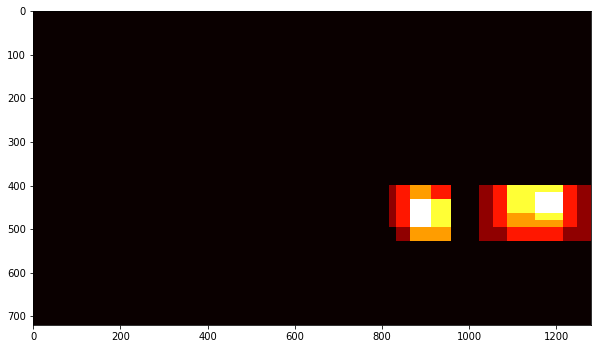

In [166]:
# Generate heat map

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

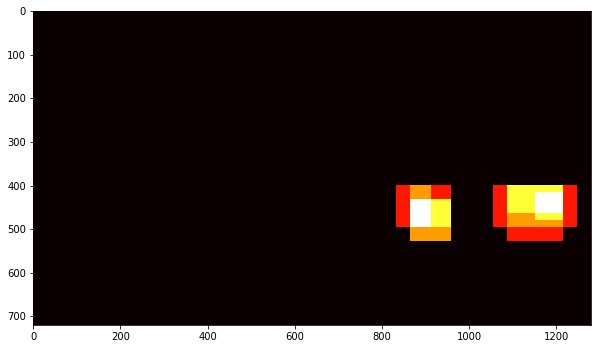

In [168]:
# Apply threshold to remove low intesity detections

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Convert Heatmap into Car Labels
Convert heatmaps into labeled detection zones so that a single bounding box can be drawn for each car (in next step).

2 cars found


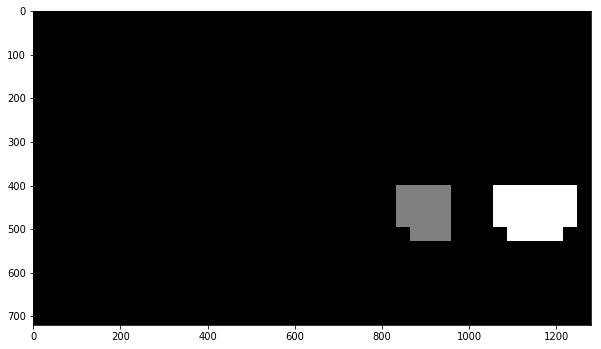

In [169]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes

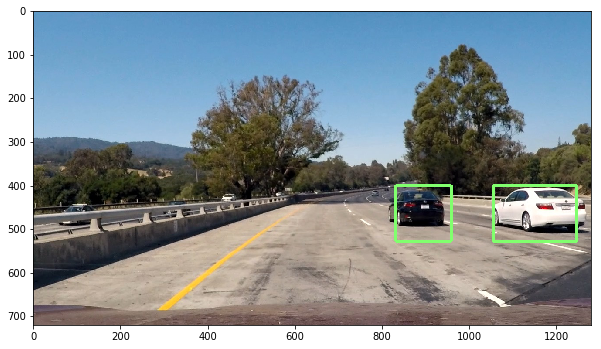

In [174]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

&nbsp;

---

## Step 4 | Video Stream
Run your pipeline on a video stream with recurring detections frame by frame that reject outliers and follow detected vehicles.

In [295]:
def process_single_frame(img):
    '''Test function for detecting cars and drawing bounding boxes in individual frames / test images.
    '''
    rectangles = mult_sliding_windows(img) 
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

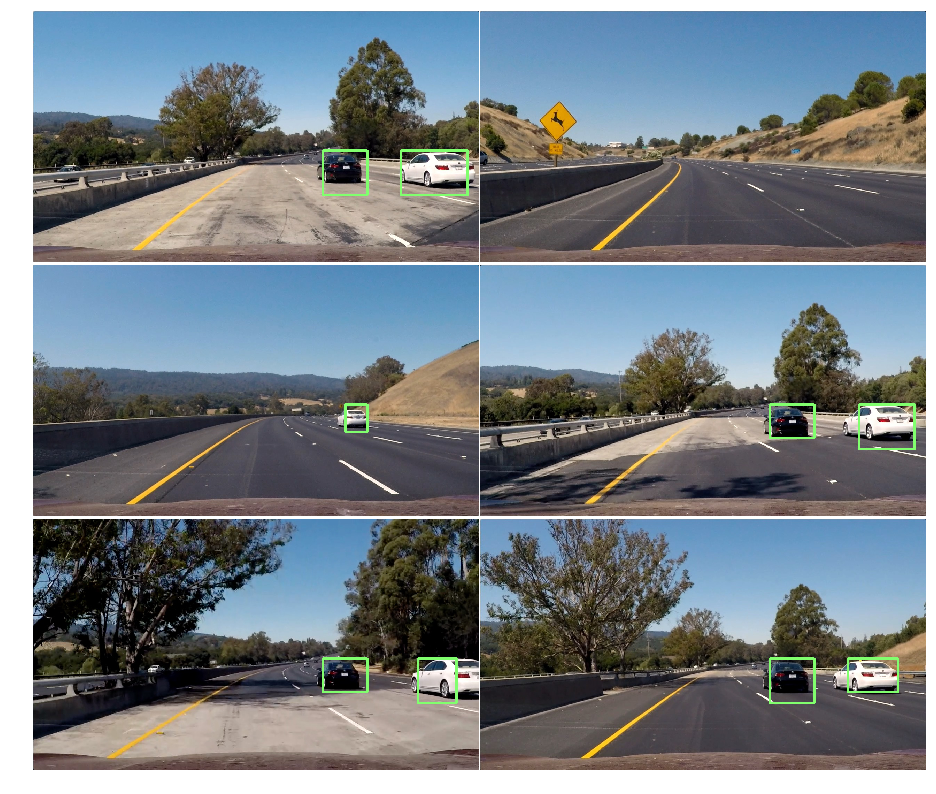

In [183]:
test_images = glob.glob('test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_single_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [287]:
# Store data from most recent video frames

class vehicleDetect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects, n=25):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > n:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-n:]


In [298]:
def vehicle_pipeline(img):
    '''Pipeline for detecting cars and drawing bounding boxes. Processes frames taking into account 
    recent history of bounding boxes in previous frames.
    '''
    rectangles = mult_sliding_windows(img) 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img


### Run on Test Video Clip

In [242]:
det = vehicleDetect()

test_out_file = 'test_video_out_2.mp4'
clip_test = VideoFileClip('videos/test_video.mp4')
clip_test_out = clip_test.fl_image(vehicle_pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:13<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 12.4 s, sys: 2.22 s, total: 14.6 s
Wall time: 14.6 s


In [189]:
det = vehicleDetect()

output_filename = 'project_video_out_1.mp4'
video_source = VideoFileClip('videos/project_video.mp4')
video_out = video_source.fl_image(vehicle_pipeline)
%time video_out.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video project_video_out_1.mp4
[MoviePy] Writing video project_video_out_1.mp4


100%|█████████▉| 1260/1261 [07:23<00:00,  2.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_1.mp4 

CPU times: user 6min 44s, sys: 1min 7s, total: 7min 52s
Wall time: 7min 24s


&nbsp;

---

## Step 5 | Incorporate Lane Detection

### Lane Detection Pipeline
Below is a copy of the lane detection pipeline that I used in [Project 4](https://github.com/tommytracey/udacity/tree/master/self-driving-nano/projects/4-advanced-lane-lines).

In [260]:
# Undistort function
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


# Gradient magnitude using both X and Y
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # X and Y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Gradient magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8-bit integer
    scaled_sobel = np.uint8(255 * mag / np.max(mag))
    
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Directional gradient for X or Y using Sobel algorithm
def abs_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Absolulte value of x or y gradient 
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale to 8-bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def hls_thresh(img, channel='S', thresh=(200, 255)):
    
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # Split the image into its color channels
    H, L, S = hls[:,:,0], hls[:,:,1], hls[:,:,2]
    
    # Select the channel to use
    if channel == 'H':
        channel = H
    elif channel == 'L':
        channel = L
    elif channel == 'S':
        channel = S
    else:
        raise ValueError("Channel not recognized. Only HLS channels can be displayed as binaries.")
    
    # Create binary mask using the chosen channel
    hls_binary = np.zeros_like(channel)
    hls_binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    
    return hls_binary


def hsv_thresh(img, channel='S', thresh=(200, 255)):
    
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Split the image into its color channels
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    
    # Select the channel to use
    if channel == 'H':
        channel = H
    elif channel == 'S':
        channel = S
    elif channel == 'V':
        channel = V
    else:
        raise ValueError("Channel not recognized. Only HSV channels can be displayed as binaries.")
    
    # Create binary mask using the chosen channel
    hsv_binary = np.zeros_like(channel)
    hsv_binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    
    return hsv_binary


# Combined thresholding function
def comb_thresh(img):
        
    # Gradient thresholds
    sx_binary = abs_thresh(img, orient='x', sobel_kernel=3, thresh=(30,130))
    sy_binary = abs_thresh(img, orient='y', sobel_kernel=3, thresh=(50,140))
    mag_binary = mag_thresh(img, sobel_kernel=5, thresh=(50,150))
    
    # Color thresholds
    s_binary = hls_thresh(img, channel='S', thresh=(120,255))  # saturation channel
    v_binary = hsv_thresh(img, channel='V', thresh=(225,255))  # value channel

    ## Combinations of above thresholds:
    
    # Gradients
    grad = np.zeros_like(sx_binary)
    grad[((sx_binary == 1) | (sy_binary == 1)) | (mag_binary == 1)] = 1
    
    # S + V channels
    sv = ((s_binary == 1) | (v_binary == 1))
    
    # Gradient + SV
    gradsv = ((grad == 1) | (sv == 1))

    # Return various combinations to test
    return sv, gradsv


# Perspective transform functions
def get_vertices(img):

    # Get image dimensions
    img_size = (img.shape[1], img.shape[0])
    img_width, img_height = img.shape[1], img.shape[0]
    
    # Define the region of interest
    y_mid = img_size[0]/2   # midpoint of image width y
    x_mid = img_size[1]/2   # midpoint of image height x
    y_up_off = 80           # y offset from horizontal midpoint for calculating upper vertices of ROI polynomial
    y_low_off = 450         # y offset from horizontal midpoint for calculating lower vertices of ROI polynomial
    x_up_off = 110          # x offset from vertical midpoint for calculating upper vertices of ROI polynomial
    x_low_off = 350         # x offset from vertical midpoint for calculating lower vertices of ROI polynomial
    
    points = [
        (y_mid - y_up_off, x_mid + x_up_off),   
        (y_mid + y_up_off, x_mid + x_up_off),
        (y_mid + y_low_off, x_mid + x_low_off),
        (y_mid - y_low_off, x_mid + x_low_off),
    ]
    src = np.float32(points)
    
    # Define warp points as dst 
    dst = np.float32([
        [y_mid - y_low_off, 0],
        [y_mid + y_low_off, 0],
        [y_mid + y_low_off, img_height],
        [y_mid - y_low_off, img_height],
    ])
    
    return src, dst


def perspective_transform(img, src, dst):

    # Calculate perspective transforms
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Apply perspective transformation to image
    img_size = (img.shape[1], img.shape[0])       
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


def draw_lines(img, vertices):
    points= np.int32([vertices])
    img_lines = cv2.polylines(img, points, True, (0,255,0), thickness=2)
    
    return img_lines


# Use warped binary to identify lane lines using sliding windows approach
def find_lines(binary_warped, show=False):

    # Make sure binary doesn't have float values
    binary_warped = binary_warped.astype('uint8')
    
    if show:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if show:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)         
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if show:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        fig2 = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
        ax3 = fig2.add_subplot(1, 1, 1)
        ax3.imshow(out_img, interpolation='none')
        ax3.plot(left_fitx, ploty, color='yellow')
        ax3.plot(right_fitx, ploty, color='yellow')    
        ax3.set_title('Sliding Windows & Polynomial Fit')
        plt.show()  
        
    return left_fit, right_fit


# Function that uses the last frame as reference for fitting the next frame
def use_last_frame(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    left_lane_inds = (
        (nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
     
    return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds


def radius_center(ploty, leftx, rightx, lefty, righty):
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curve_radius = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curve_radius = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    radius = np.mean([left_curve_radius, right_curve_radius])

    left_y_max = np.argmax(lefty)
    right_y_max = np.argmax(righty)
    center_x = (leftx[left_y_max] + rightx[right_y_max])/2
    center_offset = (640 - center_x) * xm_per_pix

    return radius, center_offset


# Function for drawing complete lane markings back onto the original image
def project_back(binary_warped, original_image, undist, Minv, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv,
                                  (original_image.shape[1], original_image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


# Moving average function
def moving_average(radius, center_offset, left, right, plot):

    global count
    if count == 5:
        recent_radius.pop(0)
        recent_center_offset.pop(0)
        recent_left_fitx.pop(0)
        recent_right_fitx.pop(0)
        recent_ploty.pop(0)
    else:
        count += 1
    recent_radius.append(radius)
    recent_center_offset.append(center_offset)
    recent_left_fitx.append(left)
    recent_right_fitx.append(right)
    recent_ploty.append(plot)
    if count > 5:
        exit()
        

In [249]:
def lane_pipeline(image):

    undist = undistort(image)
    src, dst = get_vertices(undist)
    warped, M, Minv = perspective_transform(undist, src, dst)
    warped_binary_sv, warped_binary = comb_thresh(warped)
    
    global first, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty
    
    if first:
        left_fit, right_fit = find_lines(warped_binary)
        left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, _, _ = \
            use_last_frame(warped_binary, left_fit, right_fit)
        first = False

    left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, _, _ = \
        use_last_frame(warped_binary, left_fit, right_fit)
    
    radius, center_offset = radius_center(ploty, leftx, rightx, lefty, righty)

    moving_average(radius, center_offset, left_fitx, right_fitx, ploty)

    result = project_back(warped_binary, image, undist, Minv,
                          np.add.reduce(recent_left_fitx) / count,
                          np.add.reduce(recent_right_fitx) / count,
                          np.add.reduce(recent_ploty) / count)

    cv2.putText(result, 'Radius: {0:.1f}m '.format(np.add.reduce(recent_radius) / count), (50, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, bottomLeftOrigin=False)
    cv2.putText(result, 'Center Offset: {0:.2f}m'.format(np.add.reduce(recent_center_offset) / count), (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, bottomLeftOrigin=False)
    
    
    return result

In [247]:
# Set global variables for moving average

count = 0
first = True
left_fitx = None
right_fitx = None
ploty = None
left_fit = None
right_fit = None
leftx = None
rightx = None
lefty = None
righty = None

# Create placeholder lists for storing recent values
recent_radius = []
recent_center_offset = []
recent_left_fitx = []
recent_right_fitx = []
recent_ploty = []


In [258]:
# Camera calibration variables
dist = pandas.read_pickle('data/calibration1.p')['dist']
mtx = pandas.read_pickle('data/calibration1.p')['mtx']

### Combine Lane & Vehicle Detection Pipelines

In [262]:
def lane_car(img):
    car_img = vehicle_pipeline(img)
    lane_img = lane_pipeline(car_img)
    
    return lane_img

In [263]:
det = vehicleDetect()

test_out_file = 'test_video_out_2.mp4'
clip_test = VideoFileClip('videos/test_video.mp4')
clip_test_out = clip_test.fl_image(lane_car)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 19.8 s, sys: 3.61 s, total: 23.4 s
Wall time: 20.1 s


In [265]:
det = vehicleDetect()

output_filename = 'project_video_out_2.mp4'
video_source = VideoFileClip('videos/project_video.mp4')
video_out = video_source.fl_image(lane_car)
%time video_out.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video project_video_out_2.mp4
[MoviePy] Writing video project_video_out_2.mp4



 12%|█▏        | 152/1261 [01:15<09:03,  2.04it/s]


 24%|██▍       | 303/1261 [02:30<07:45,  2.06it/s]


 36%|███▌      | 454/1261 [03:46<07:07,  1.89it/s]


 48%|████▊     | 605/1261 [05:02<05:30,  1.99it/s]


 60%|█████▉    | 756/1261 [06:18<04:19,  1.94it/s]


 72%|███████▏  | 907/1261 [07:35<03:05,  1.91it/s]


 84%|████████▍ | 1057/1261 [08:51<01:43,  1.97it/s]


 96%|█████████▌| 1205/1261 [10:07<00:31,  1.76it/s]


100%|█████████▉| 1260/1261 [10:35<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_2.mp4 

CPU times: user 10min 56s, sys: 2min 6s, total: 13min 3s
Wall time: 10min 36s
